### PCA - Analisis de componentes principales

link referencia: https://www.cienciadedatos.net/documentos/py19-pca-python.html#:~:text=El%20an%C3%A1lisis%20de%20componentes%20principales,vez%20que%20conserva%20su%20informaci%C3%B3n.

#### Carga de datos

In [20]:
# Importamos librerias a utilizar
import pandas as pd
import numpy as np
#Graficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns
#PCA
# ==============================================================================
import statsmodels.api as sm
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
# ==============================================================================
#Calculo de metricas del algoritmo seleccionado
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# ==============================================================================
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lectura del csv
df_air = pd.read_csv('Airlines.csv', sep=',')
df_air.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [3]:
df_air.drop(df_air[df_air.Length == 0].index, inplace=True)
df_air.shape

(539379, 9)

#### Exploracion inicial

In [4]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539379 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539379 non-null  int64 
 1   Airline      539379 non-null  object
 2   Flight       539379 non-null  int64 
 3   AirportFrom  539379 non-null  object
 4   AirportTo    539379 non-null  object
 5   DayOfWeek    539379 non-null  int64 
 6   Time         539379 non-null  int64 
 7   Length       539379 non-null  int64 
 8   Delay        539379 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 41.2+ MB


#### Preparacion de datos
En el siguiente paso lo que hacemos es convertir aquellas variables categoricas en numéricas para poder aplicar el algoritmo de predicción. 

In [5]:
#Comenzamos con la preparacion de nuestros datos
df_dummy = pd.get_dummies(df_air, drop_first=True)
df_dummy

,id,Flight,DayOfWeek,Time,Length,Delay,Airline_AA,Airline_AS,Airline_B6,Airline_CO,...,AirportTo_TXK,AirportTo_TYR,AirportTo_TYS,AirportTo_UTM,AirportTo_VLD,AirportTo_VPS,AirportTo_WRG,AirportTo_XNA,AirportTo_YAK,AirportTo_YUM
0,1,269,3,15,205,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1558,3,15,222,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2400,3,20,165,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2466,3,20,195,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,108,3,30,202,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,178,5,1439,326,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
539379,539380,398,5,1439,305,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539380,539381,609,5,1439,255,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539381,539382,78,5,1439,313,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Definición de variables Target
En base al objetivo planteado de poder predecir que vuelos puede presentar demoras, nuestra variable objetivo será "Delay"

A continuación dividimos nuestro dataset en 2 partes:
- X: contendrá las variables con las cuales vamos a construir el modelo. Dichas variables se consideran independientes.
- Y: contendrá la variable Delay y se considera nuestra variable dependiente.

In [6]:
#Separamos los datos de entrada de la salida
X = df_dummy.drop(['Delay'], axis=1) #Elimino de mi dataset la variable a predecir
y = df_dummy.Delay #Defino el Target

#### Divimos el dataset.

En este caso utilizaremos:
- El 70% del mismo para el entrenamiento de los distintos algoritmos.
- El 30% restante como test de los algoritmos.

In [7]:
from sklearn.model_selection import train_test_split #Importamos la libreria para separar en train y test

#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11) 

#### PCA: Análisis de Componentes Principales
Luego de convertir todas nuestras variables independientes en numéricas nos encontramos con un dataset que contiene 607 columnas o variables de análisis.

Con el fin de verificar si es posible reducir la dimensionalidad aplicamos el método PCA o Análisis de Componentes Principales.

El análisis de componentes principales (Principal Component Analysis PCA) es un método de reducción de dimensionalidad que permite simplificar la complejidad de espacios con múltiples dimensiones a la vez que conserva su información

El método gira los datos de forma que, desde un punto de vista estadístico, no exista una correlación entre las características rotadas pero que conserven la mayor cantidad posible de la varianza de los datos originales.

##### Escalado de las variables

El proceso de PCA identifica las direcciones con mayor varianza. 
Como la varianza de una variable se mide en sus mismas unidades elevadas al cuadrado, si antes de calcular las componentes no se estandarizan todas las variables para que tengan media cero y desviación estándar de uno, aquellas variables cuya escala sea mayor dominarán al resto. De ahí que sea recomendable estandarizar siempre los datos.

In [8]:
#Normalizamos los datos para que PCA funcione mejor!
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Aplicación del modelo PCA

In [9]:
#Aplicacion de PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#### Interpretación

Una vez entrenado el objeto PCA, pude accederse a toda la información de las componentes creadas.
*components_* contiene el valor de los loadings  ϕ  que definen cada componente. Las filas se corresponden con las componentes principales (ordenadas de mayor a menor varianza explicada). Las filas se corresponden con las variables de entrada.

In [15]:
# Se convierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = pca.components_,
    columns = X.columns
).round(3)

,id,Flight,DayOfWeek,Time,Length,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,...,AirportTo_TXK,AirportTo_TYR,AirportTo_TYS,AirportTo_UTM,AirportTo_VLD,AirportTo_VPS,AirportTo_WRG,AirportTo_XNA,AirportTo_YAK,AirportTo_YUM
0,-0.009,0.520,-0.004,-0.002,-0.281,-0.103,-0.142,-0.117,-0.103,-0.021,...,0.006,0.005,0.029,0.000,0.015,0.029,-0.013,0.031,-0.014,0.017
1,0.000,0.071,0.007,0.016,-0.088,-0.058,0.085,-0.080,-0.052,-0.070,...,-0.001,-0.001,-0.002,-0.003,-0.001,-0.003,0.011,-0.001,0.012,0.017
2,-0.000,0.022,-0.003,0.004,0.001,-0.049,0.254,-0.047,-0.041,-0.127,...,-0.006,-0.005,-0.023,-0.006,-0.016,-0.031,0.038,-0.020,0.040,0.014
3,-0.002,0.035,0.004,-0.007,0.053,0.019,0.439,0.004,0.026,0.082,...,0.003,0.003,0.016,0.003,0.011,0.021,0.084,0.016,0.089,-0.011
4,-0.013,-0.015,-0.013,0.020,-0.275,-0.265,0.093,-0.130,-0.129,0.041,...,-0.009,-0.007,0.001,0.008,0.022,0.026,0.032,-0.010,0.032,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,-0.001,0.675,-0.004,0.001,0.000,0.061,0.061,0.083,-0.037,-0.005,...,0.002,0.003,-0.004,-0.003,0.003,0.007,-0.000,0.004,0.001,0.004
602,-0.001,-0.184,0.001,0.001,0.000,-0.348,-0.185,-0.209,-0.230,-0.291,...,-0.001,-0.001,-0.009,0.001,-0.001,-0.003,0.001,-0.002,0.000,-0.001
603,-0.000,-0.001,-0.000,0.000,-0.000,0.002,0.001,0.001,0.001,0.002,...,0.001,0.000,0.002,0.000,0.001,0.001,0.000,0.002,0.000,0.001
604,-0.000,-0.000,0.000,-0.000,0.000,0.002,0.001,0.001,0.001,0.002,...,-0.013,-0.011,-0.047,-0.007,-0.013,-0.035,-0.010,-0.046,-0.011,-0.025


Una vez calculadas las componentes principales, se puede conocer la varianza explicada por cada una de ellas, la proporción respecto al total y la proporción de varianza acumulada. Esta información está almacenada en los atributos *explained_variance_* y *explained_variance_ratio_* del modelo.

In [16]:
#Análisis de la varianza explicada para cada componente
explained_variance = pca.explained_variance_ratio_
explained_variance

array([4.88742051e-03, 4.07647222e-03, 3.91214111e-03, 3.71375462e-03,
       3.54811571e-03, 3.40325946e-03, 3.22785387e-03, 3.05544160e-03,
       2.86640220e-03, 2.84997725e-03, 2.79412415e-03, 2.76937822e-03,
       2.75148279e-03, 2.73738382e-03, 2.72505302e-03, 2.67105554e-03,
       2.62431650e-03, 2.58458800e-03, 2.55797528e-03, 2.47104172e-03,
       2.42540872e-03, 2.42015672e-03, 2.38494407e-03, 2.36323808e-03,
       2.32986001e-03, 2.32442371e-03, 2.30225488e-03, 2.28083788e-03,
       2.26802110e-03, 2.25463926e-03, 2.21978556e-03, 2.20107275e-03,
       2.19252982e-03, 2.17743041e-03, 2.16020444e-03, 2.14490329e-03,
       2.14416744e-03, 2.12482842e-03, 2.11546009e-03, 2.10773993e-03,
       2.08789788e-03, 2.07961322e-03, 2.07498079e-03, 2.07218869e-03,
       2.06650259e-03, 2.04927922e-03, 2.03875527e-03, 2.03516324e-03,
       2.03364805e-03, 2.03257356e-03, 2.02719431e-03, 2.01780840e-03,
       2.00704255e-03, 2.00006652e-03, 1.99759323e-03, 1.98175656e-03,
      

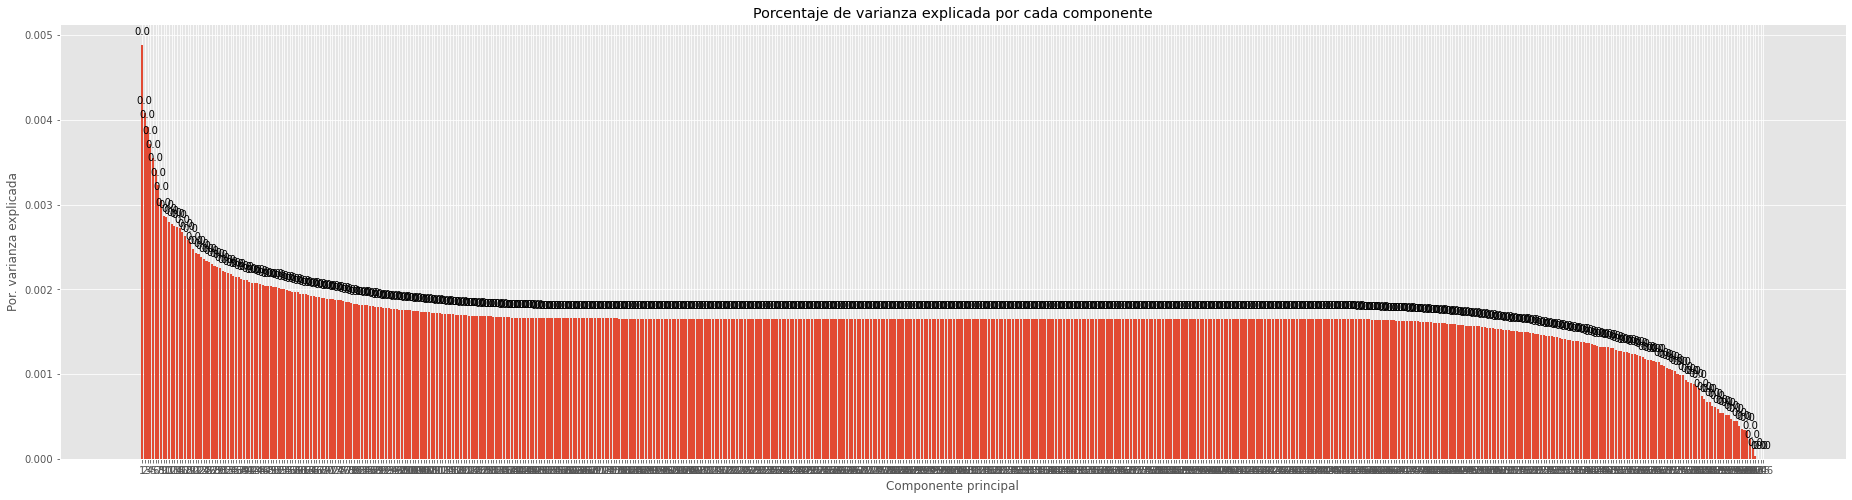

In [17]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 8))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_dummy.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
#ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');



In [18]:
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
prop_varianza_acum

array([0.00488742, 0.00896389, 0.01287603, 0.01658979, 0.0201379 ,
       0.02354116, 0.02676902, 0.02982446, 0.03269086, 0.03554084,
       0.03833496, 0.04110434, 0.04385582, 0.04659321, 0.04931826,
       0.05198932, 0.05461363, 0.05719822, 0.0597562 , 0.06222724,
       0.06465265, 0.0670728 , 0.06945775, 0.07182099, 0.07415085,
       0.07647527, 0.07877752, 0.08105836, 0.08332638, 0.08558102,
       0.08780081, 0.09000188, 0.09219441, 0.09437184, 0.09653204,
       0.09867695, 0.10082112, 0.10294594, 0.1050614 , 0.10716914,
       0.10925704, 0.11133666, 0.11341164, 0.11548382, 0.11755033,
       0.11959961, 0.12163836, 0.12367353, 0.12570717, 0.12773975,
       0.12976694, 0.13178475, 0.13379179, 0.13579186, 0.13778945,
       0.13977121, 0.14174295, 0.14371329, 0.145677  , 0.14762738,
       0.14957734, 0.15151845, 0.15344866, 0.15537311, 0.15729638,
       0.15920692, 0.1611137 , 0.16301469, 0.16491043, 0.16680099,
       0.16868577, 0.17056935, 0.17244563, 0.17431968, 0.17618

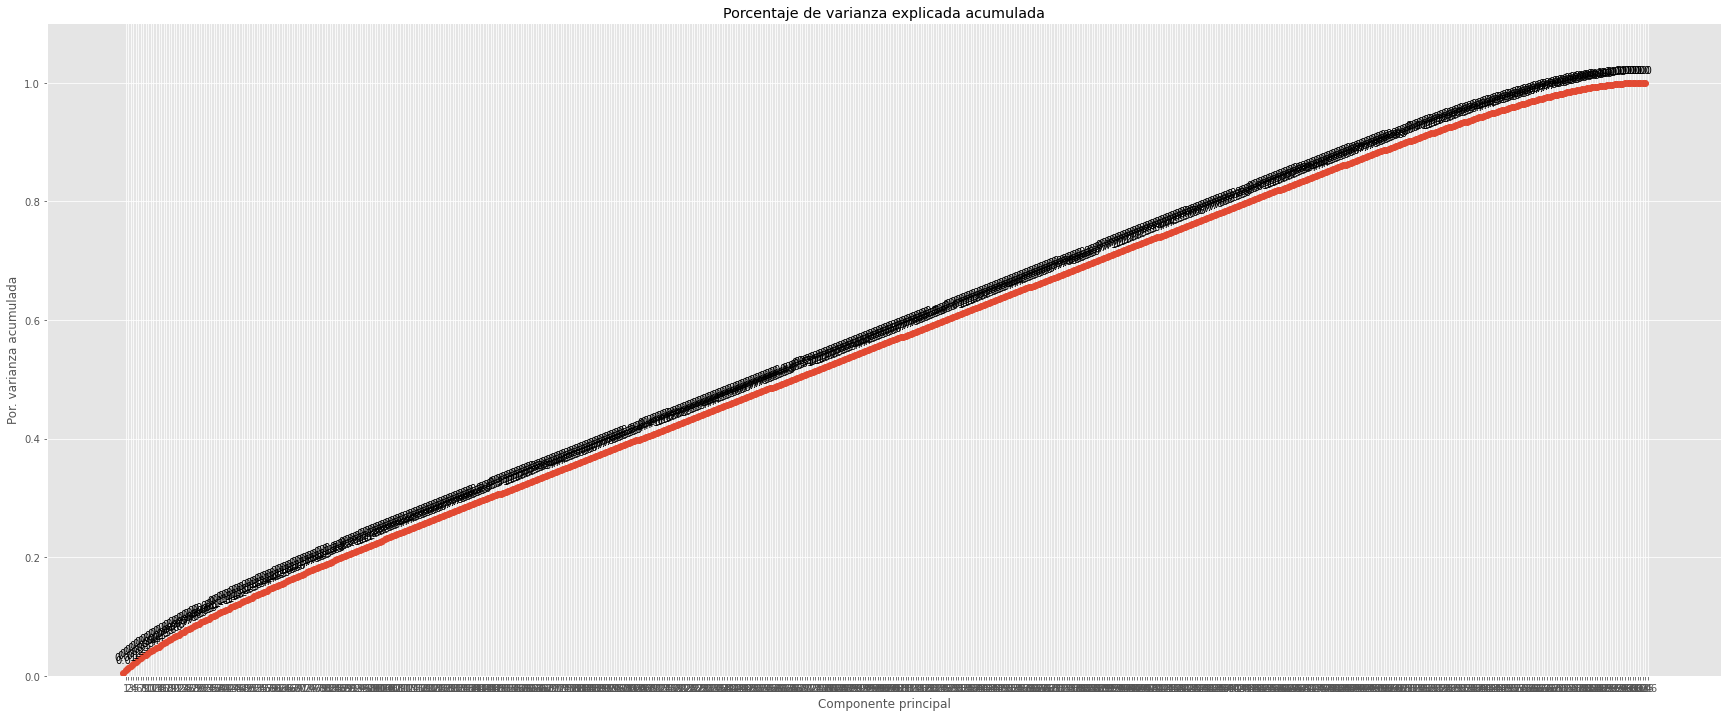

In [19]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 12))
ax.plot(
    np.arange(len(df_dummy.columns)-1),
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df_dummy.columns)), prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

Aplicamos el modelo RandomForest con todas las componentes obtenidas al aplicar PCA y vemos como funciona

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Creación del modelo
model_rf_ini = RandomForestClassifier(max_depth=2, random_state=0)
model_rf_ini.fit(X_train, y_train)

# Predicción
y_pred_ini = model_rf_ini.predict(X_test)

El % de aciertos sobre el set de evaluación es: 0.5989160394032654
El % de precisión sobre la evaluación es: 0.758959496713084


In [23]:
test_accuracy = accuracy_score(y_test, y_pred_ini)
test_prec = precision_score(y_test, y_pred_ini)
test_recall = recall_score(y_test, y_pred_ini)
test_f1 = f1_score(y_test, y_pred_ini)

print('El % de aciertos sobre el set de evaluación es:',test_accuracy)
print('El % de precisión sobre la evaluación es:',test_prec)
print('Recall o la Sensibilidad del algoritmo es:',test_recall)
print('La especificidad del modelo es:',test_f1)


El % de aciertos sobre el set de evaluación es: 0.5989160394032654
El % de precisión sobre la evaluación es: 0.758959496713084
Recall o la Sensibilidad del algoritmo es: 0.14865426150523342
La especificidad del modelo es: 0.2486136034732272


##### Probamos aplicar nuevamente el método PCA pero esta vez considerando 400 componentes principales 
(de un total de 600 aprox)
Según el análisis anteriormente planteado sobre la varianza acumulada al aplicar PCA, los primeros 400 componentes representan aproximadamente un 75% del peso del modelo.

In [25]:
#Separamos los datos de entrada de la salida
X = df_dummy.drop(['Delay'], axis=1) #Elimino de mi dataset la variable a predecir
y = df_dummy.Delay #Defino el Target

#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11) 

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
pca2 = PCA(n_components=400)
X_train_2 = pca2.fit_transform(X_train)
X_test_2 = pca2.transform(X_test)

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Creación del modelo
model_rf2 = RandomForestClassifier(max_depth=2, random_state=0)
model_rf2.fit(X_train_2, y_train)

# Predicción
y_pred2 = model_rf2.predict(X_test_2)

#### Matriz de confusión

[[83757  5829]
 [56702 15526]]


<AxesSubplot:>

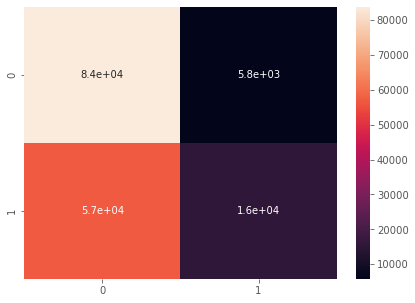

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Matriz de Confusión
print(confusion_matrix(y_test, y_pred2))

#Ploteamos la Matriz
#plot_confusion_matrix(classifier, X_test_2, y_test)
#plt.show()

mat = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(7, 5))
sns.heatmap(mat, annot=True) #Plot a través de Seaborn

#### Métricas del modelo

In [34]:
#Calculo de metricas del algoritmo seleccionado
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_accuracy = accuracy_score(y_test, y_pred2)
test_prec = precision_score(y_test, y_pred2)
test_recall = recall_score(y_test, y_pred2)
test_f1 = f1_score(y_test, y_pred2)

print('El % de aciertos sobre el set de evaluación es:',test_accuracy)
print('El % de precisión sobre la evaluación es:',test_prec)
print('Recall o la Sensibilidad del algoritmo es:',test_recall)
print('La especificidad del modelo es:',test_f1)


El % de aciertos sobre el set de evaluación es: 0.6135624853226544
El % de precisión sobre la evaluación es: 0.7270428471084055
Recall o la Sensibilidad del algoritmo es: 0.2149581879603478
La especificidad del modelo es: 0.3318124018251178


#### Curva ROC

La curva AUC-ROC es una métrica de rendimiento que se utiliza para medir el rendimiento del modelo de clasificación en diferentes valores de umbral. Cuanto mayor sea el valor de AUC (Área bajo la curva), mejor será nuestro clasificador para predecir las clases. AUC-ROC se utiliza principalmente en problemas de clasificación binaria.

La curva ROC se traza entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR), es decir, TPR en el eje y y FPR en el eje y. AUC es el área bajo la curva ROC.

Un clasificador excelente tiene un valor AUC cercano a 1, mientras que un clasificador de bajo rendimiento tiene un valor AOC cercano a 0. Un clasificador con una puntuación AOC de 0.5 no tiene ninguna capacidad de separación de clases.

In [35]:
#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = classifier.predict_proba(X_test_2)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'classifier' is not defined